In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
from imgaug import augmenters as iaa
import imgaug as ia

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Config

In [3]:
class RoofTypeConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    NAME = "roof_types"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    BATCH_SIZE = IMAGES_PER_GPU * GPU_COUNT
    
    #RPN_NMS_THRESHOLD = 0.8
    
    LEARNING_RATE = 0.001
    
    DETECTION_MAX_INSTANCES = 400
    MAX_GT_INSTANCES = 400

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 16 roof types

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_CHANNEL_COUNT = 3

    # Use smaller anchors because our image and objects are small
    BACKBONE_STRIDES = (4, 8, 16, 32, 64, 128, 256)
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256, 384)  # anchor side in pixels
    
    #RPN_ANCHOR_SCALES = (10, 20, 40, 80, 160)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 300

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 15
    
config = RoofTypeConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               (4, 8, 16, 32, 64, 128, 256)
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [4]:
class RoofTypeDataset(utils.Dataset):
    def __init__(self):
        super().__init__()
        self.roofs = []
        self.types = {
            '1000':1,
            '2100':2,
            '3100':3,
            '3200':4,
            '3300':5,
            '3400':6
        }

    def load_roof_data(self, dataset_dir):
        """Load a subset of the RoofType dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        # Add classes
        self.add_class("roof_types", 1, "1000")
        self.add_class("roof_types", 2, "2100")
        self.add_class("roof_types", 3, "3100")
        self.add_class("roof_types", 4, "3200")
        self.add_class("roof_types", 5, "3300")
        self.add_class("roof_types", 6, "3400")
        
        
        self.dataset_dir = dataset_dir
        for image_set in os.listdir(self.dataset_dir):
            image = os.path.join(self.dataset_dir, image_set, '{}.tif'.format(image_set))
            self.add_image(
                "roof_types",
                image_id=os.path.split(image)[0],
                path=image
            )

    def load_mask(self, image_id):
        """Load instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "roof_types":
            return super(self.__class__, self).load_mask(image_id)

        mask_arrs = []
        mask_lbls = np.empty(0).astype(np.int)
        image_id = image_info['id']
        mask_dirs = [os.path.join(image_id, md) for md in os.listdir(image_id) if os.path.isdir(os.path.join(image_id, md))]
        for mask_dir in mask_dirs:
            mask_type = os.path.split(mask_dir)[1]
            for file in os.listdir(mask_dir):
                arr = skimage.io.imread(os.path.join(mask_dir, file)).astype(np.bool)
                mask_arrs.append(arr)
                mask_lbls = np.append(mask_lbls, self.types[mask_type])
        mask_stack = np.dstack(np.asarray(mask_arrs))
        return mask_stack, mask_lbls
        

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "roof_types":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Dataset

In [5]:
path_train = r'C:\Users\MoritzWollenhaupt\Desktop\chips_single_masks_v2_enrich\train'
path_val = r'C:\Users\MoritzWollenhaupt\Desktop\chips_single_masks_v2_enrich\val'
path_test = r'C:\Users\MoritzWollenhaupt\Desktop\chips_single_masks_v2_enrich\test'

In [6]:
dataset_train = RoofTypeDataset()
dataset_train.load_roof_data(path_train)
dataset_train.prepare()

dataset_val = RoofTypeDataset()
dataset_val.load_roof_data(path_val)
dataset_val.prepare()

dataset_test = RoofTypeDataset()
dataset_test.load_roof_data(path_test)
dataset_test.prepare()

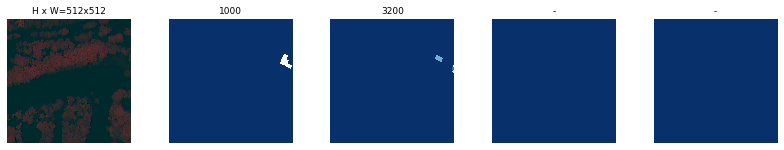

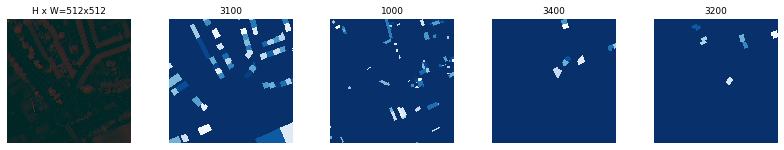

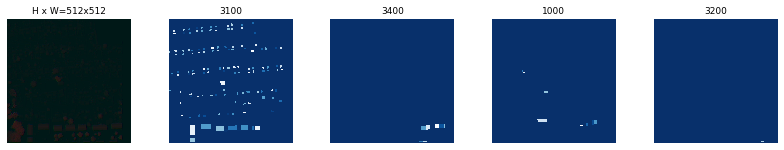

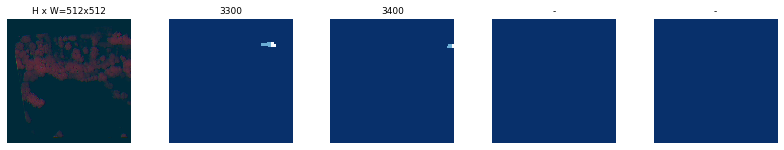

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
#init_with = "coco"  # imagenet, coco, or last
init_with = "last"
#init_with = "imagenet"


if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
epochs = 250

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=epochs, 
            layers='heads',
           )

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
epochs = 5

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=epochs, 
            layers="all")

## Detection

In [8]:
class InferenceConfig(RoofTypeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.55
    DETECTION_NMS_THRESHOLD = 0.2
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  c:\Users\MoritzWollenhaupt\Desktop\MRCNN\Mask_RCNN\logs\roof_types20200611T1035\mask_rcnn_roof_types_0301.h5
Re-starting from epoch 301


original_image           shape: (512, 512, 3)         min:    0.00000  max:  104.00000  uint16
image_meta               shape: (19,)                 min:    0.00000  max:  512.00000  int32
gt_class_id              shape: (57,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (57, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 57)        min:    0.00000  max:    1.00000  bool


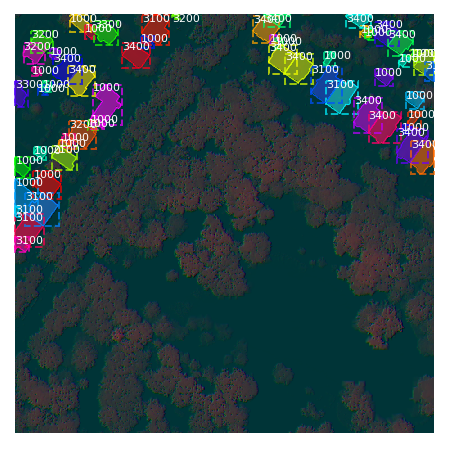

In [15]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  104.00000  uint16
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:    0.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65532, 4)         min:   -0.53137  max:    1.10376  float32


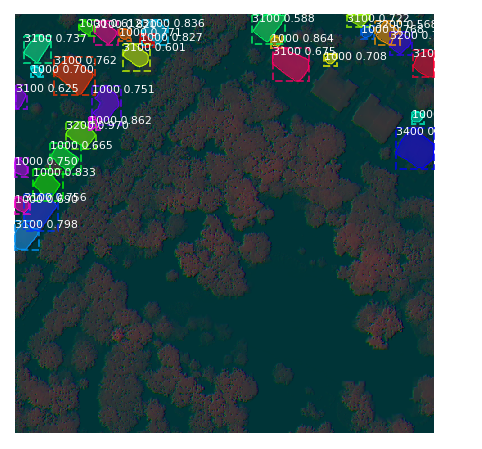

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [58]:
np.unique(r['class_ids'])

array([1, 3, 4, 5, 6])

## Evaluation

In [53]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
PRECISIONS = []
RECALLS = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    PRECISIONS.append(precisions)
    RECALLS.append(recalls)
    
print("mAP: ", np.mean(APs))

mAP:  0.2770527705871952


In [ ]:
img = dataset_test.load_image(0)

In [ ]:
dataset_test.image_reference(0)

In [ ]:
results = model.detect([img], verbose=1)
r = results[0]

In [ ]:
masks = r['masks']

In [ ]:
for i in range(masks.shape[2]):
    skimage.io.imsave(r'C:\Users\MoritzWollenhaupt\Desktop\class_{}_img_{}.tif'.format(dataset_test.class_names[r['class_ids'][i]], i), masks[:,:,i])